In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr

In [37]:
import warnings
warnings.filterwarnings('ignore')

In [38]:
df = pdr.get_data_fred('ICNSA')
df.head()

,ICNSA
DATE,
2019-03-02,220540
2019-03-09,209302
2019-03-16,194335
2019-03-23,190023
2019-03-30,183775


<Axes: xlabel='DATE'>

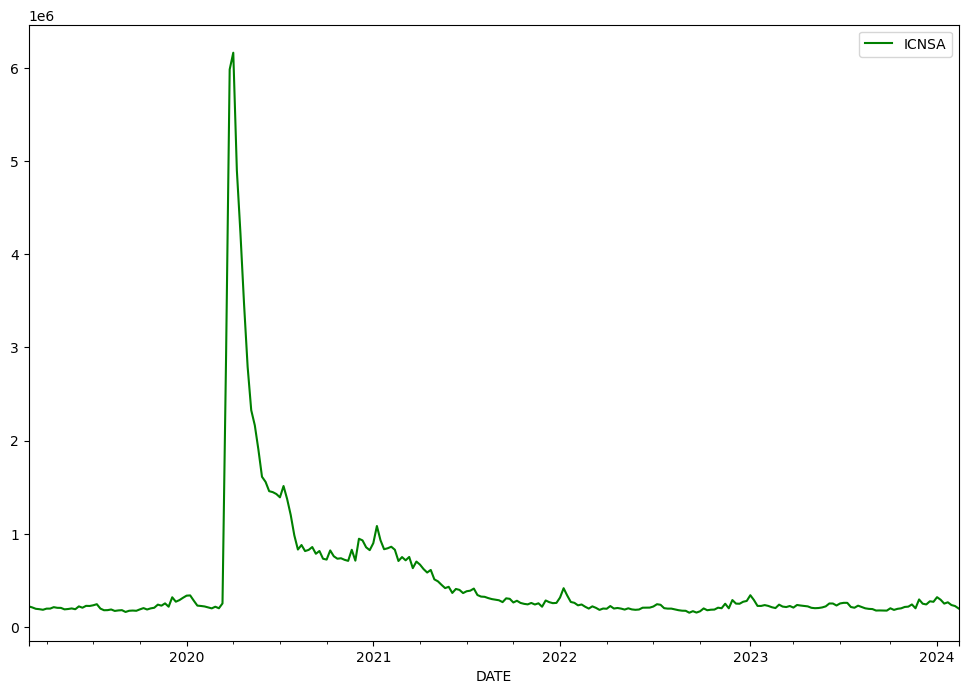

In [39]:
df.plot(figsize=(12,8),c='green')


# Identification of covid start date and end date with empirical analysis

Visualizing the plot allows for the observation of notable shifts or spikes in the data, potentially signaling the onset and conclusion of the COVID-19 pandemic's impact. Starting from January 2020, a period when numerous countries experienced significant repercussions from COVID-19, the plot unveils spikes in unemployment claims due to lockdown measures.

The identification of pivotal changes involves pinpointing sharp increases in initial claims, serving as a marker for the pandemic's initiation. Additionally, tracking the gradual decline towards pre-pandemic levels signifies the potential conclusion of the pandemic's influence. Around January 2021, as recovery efforts gained momentum, employment figures began stabilizing, although the precise timeline may vary across regions.

<Axes: xlabel='DATE'>

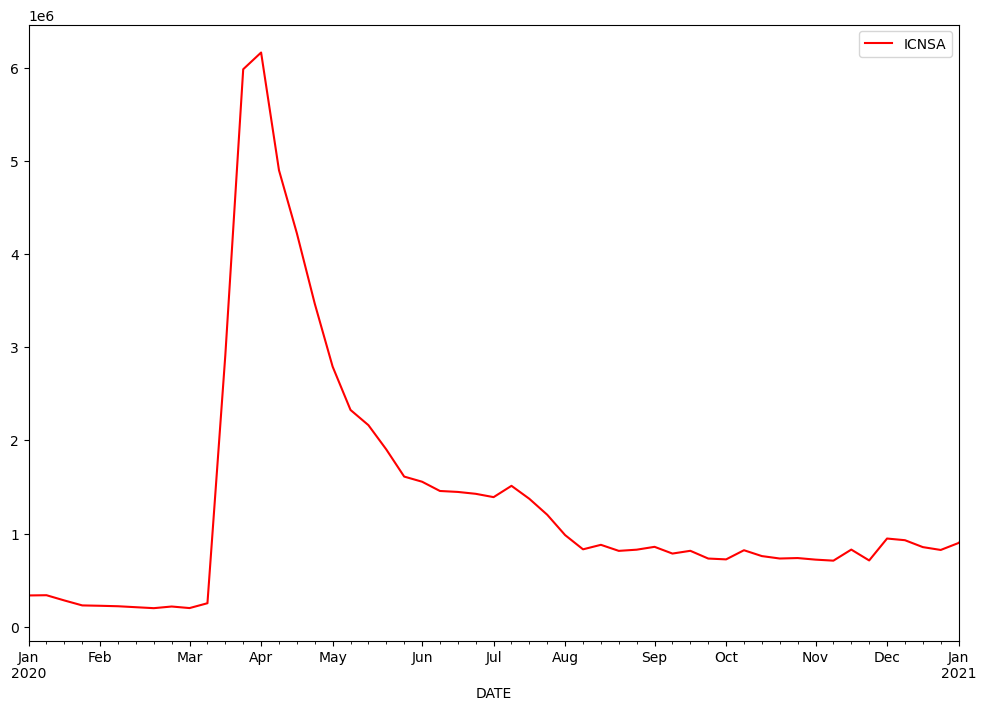

In [40]:
# let's extract and plot the covid pandemic claims
df.plot(xlim=['2020-01-01','2021-01-01'],figsize=(12,8),c='red')

In [41]:
# extracting the covid periods using loc to access date-time index
df_covid = df.loc['2020-01-01':'2021-01-01']
df_covid.head()

,ICNSA
DATE,
2020-01-04,335294
2020-01-11,337883
2020-01-18,281646
2020-01-25,228443
2020-02-01,224561


In [42]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52 entries, 2020-01-04 to 2020-12-26
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   ICNSA   52 non-null     int64
dtypes: int64(1)
memory usage: 832.0 bytes


In [43]:

# this is a weekly data..let's change it to daily data..downsampling
covid_daily = df_covid.resample('D').mean()
covid_daily.tail()

,ICNSA
DATE,
2020-12-22,NaN
2020-12-23,NaN
2020-12-24,NaN
2020-12-25,NaN
2020-12-26,823512.0


In [44]:
print(len(covid_daily))
print(covid_daily['ICNSA'].isnull().sum())

358
306


Interpolating using Cubic Spline Methodology

In [45]:
from scipy.interpolate import CubicSpline

In [46]:
pd.isnull(covid_daily.loc['2020-12-24'].ICNSA) #just to check

True

In [47]:
x = [i for i,col in enumerate(covid_daily.index) if not pd.isnull(covid_daily.loc[col].ICNSA)]
y = [covid_daily.loc[col].ICNSA for i,col in enumerate(covid_daily.index) if not pd.isnull(covid_daily.loc[col].ICNSA)]
print(x)
print(y)

[0, 7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77, 84, 91, 98, 105, 112, 119, 126, 133, 140, 147, 154, 161, 168, 175, 182, 189, 196, 203, 210, 217, 224, 231, 238, 245, 252, 259, 266, 273, 280, 287, 294, 301, 308, 315, 322, 329, 336, 343, 350, 357]
[335294.0, 337883.0, 281646.0, 228443.0, 224561.0, 219459.0, 209218.0, 198845.0, 216625.0, 199914.0, 251875.0, 2914268.0, 5981838.0, 6161268.0, 4898119.0, 4221704.0, 3466665.0, 2790860.0, 2325889.0, 2162822.0, 1902006.0, 1610909.0, 1555824.0, 1456353.0, 1446176.0, 1425969.0, 1390315.0, 1511632.0, 1372247.0, 1200962.0, 982808.0, 830266.0, 878555.0, 813744.0, 826436.0, 857006.0, 784765.0, 814441.0, 731391.0, 722387.0, 820590.0, 757745.0, 731660.0, 736618.0, 719716.0, 708717.0, 827447.0, 710901.0, 946091.0, 928178.0, 854113.0, 823512.0]


Interpolation is employed to populate missing values when downsampling data from a weekly to a daily frequency. Downsampling involves reducing the frequency of data points, such as from weekly intervals to daily intervals. This process is advantageous as it helps to simplify and condense the dataset, making it more manageable and easier to analyze. Additionally, downsampling can help in identifying long-term trends and patterns by reducing noise and variability in the data.

In [48]:
cubic_interpolate = CubicSpline(x,y,bc_type='natural')
points=[i for i in range(len(covid_daily))]
covid_daily['Interpolated'] = cubic_interpolate(points)

<Axes: xlabel='DATE'>

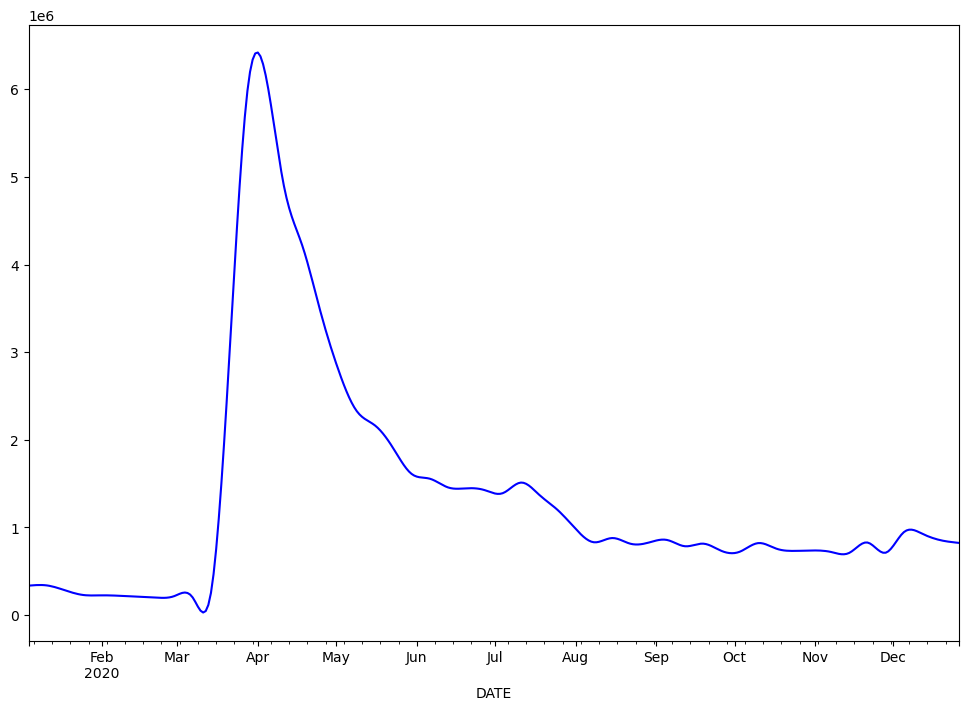

In [49]:
covid_daily['Interpolated'].plot(figsize=(12,8),c='blue')

In [50]:
covid_daily.head()

,ICNSA,Interpolated
DATE,,
2020-01-04,335294.0,335294.000000
2020-01-05,NaN,337767.513575
2020-01-06,NaN,339978.070096
2020-01-07,NaN,341662.712509
2020-01-08,NaN,342558.483760


Regarding the absence of the λ value in the code, it's important to note that the CubicSpline function in scipy.interpolate does not require a λ value. Unlike some other interpolation methods that involve a regularization parameter like λ (lambda), cubic spline interpolation using CubicSpline in scipy.interpolate utilizes a different approach called "not-a-knot" to fit the spline. This method ensures that the spline is continuous at knots, which are the points where the interpolation curve changes direction. By default, the CubicSpline function applies natural boundary conditions, which means that the second derivatives of the spline at the endpoints are set to zero. This approach ensures smoothness and continuity of the interpolation curve without the need for manually specifying a regularization parameter like λ. Therefore, CubicSpline offers a convenient and effective way to perform cubic spline interpolation without the need for additional parameter tuning.

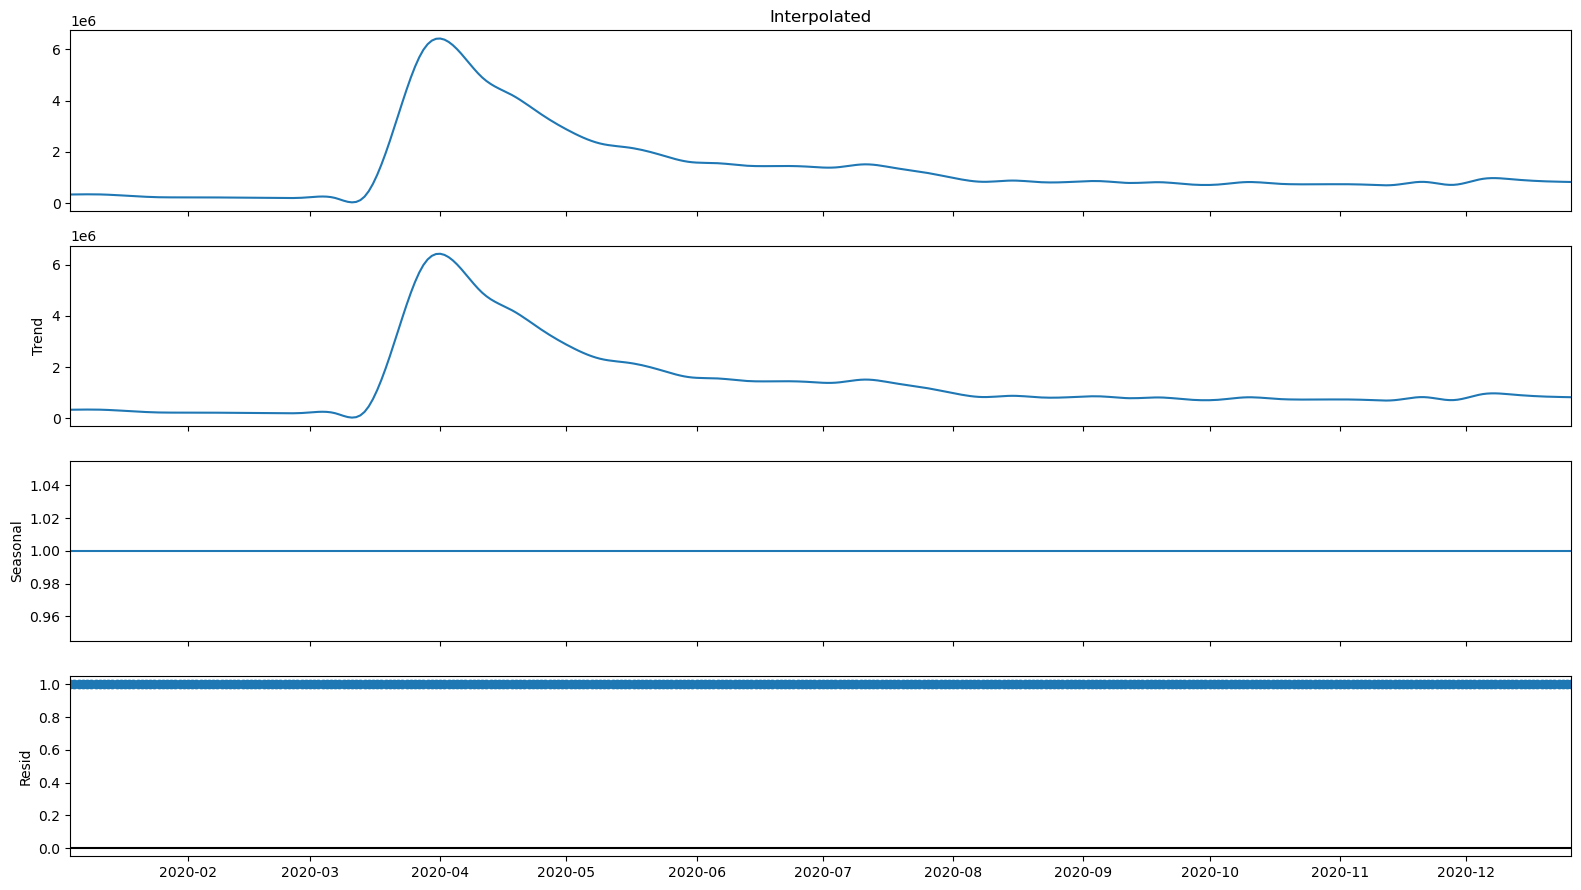

In [51]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(covid_daily['Interpolated'],period=1, model='multiplicative')
fig = result.plot();
fig.set_size_inches((16, 9))
fig.tight_layout()

In [52]:
#splitting train test split
train = covid_daily.iloc[:298]
test = covid_daily.iloc[298:]
len(test)

60

fitting multiplicative holt winters model

In [53]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
multiplicative_model = ExponentialSmoothing(train['Interpolated'],trend='mul',seasonal='mul').fit()
multiplicative_predictions = multiplicative_model.forecast(60).rename('Multiplicative HW Forecast')
multiplicative_predictions

2020-10-28    733636.670485
2020-10-29    734110.131073
2020-10-30    734333.733313
2020-10-31    734509.140858
2020-11-01    734645.628140
2020-11-02    734712.462359
2020-11-03    735571.980310
2020-11-04    735574.156498
2020-11-05    736048.867464
2020-11-06    736273.060223
2020-11-07    736448.931008
2020-11-08    736585.778744
2020-11-09    736652.789468
2020-11-10    737514.577349
2020-11-11    737516.759285
2020-11-12    737992.723931
2020-11-13    738217.508768
2020-11-14    738393.844015
2020-11-15    738531.053158
2020-11-16    738598.240852
2020-11-17    739462.304659
2020-11-18    739464.492356
2020-11-19    739941.713994
2020-11-20    740167.092472
2020-11-21    740343.893410
2020-11-22    740481.464913
2020-11-23    740548.830046
2020-11-24    741415.175787
2020-11-25    741417.369263
2020-11-26    741895.851211
2020-11-27    742121.824899
2020-11-28    742299.092757
2020-11-29    742437.027576
2020-11-30    742504.570616
2020-12-01    743373.204320
2020-12-02    743375

fitting additive holt winters model

In [54]:
additive_model = ExponentialSmoothing(train['Interpolated'],trend='add',seasonal='add').fit()
additive_predictions = additive_model.forecast(60).rename('Additive HW Forecast')
additive_predictions

2020-10-28    734432.544434
2020-10-29    735183.214026
2020-10-30    735947.527714
2020-10-31    736638.107216
2020-11-01    737424.521647
2020-11-02    738043.357440
2020-11-03    738893.406245
2020-11-04    739694.251243
2020-11-05    740444.920835
2020-11-06    741209.234522
2020-11-07    741899.814025
2020-11-08    742686.228455
2020-11-09    743305.064249
2020-11-10    744155.113054
2020-11-11    744955.958051
2020-11-12    745706.627643
2020-11-13    746470.941331
2020-11-14    747161.520833
2020-11-15    747947.935264
2020-11-16    748566.771058
2020-11-17    749416.819862
2020-11-18    750217.664860
2020-11-19    750968.334452
2020-11-20    751732.648140
2020-11-21    752423.227642
2020-11-22    753209.642073
2020-11-23    753828.477866
2020-11-24    754678.526671
2020-11-25    755479.371669
2020-11-26    756230.041261
2020-11-27    756994.354948
2020-11-28    757684.934450
2020-11-29    758471.348881
2020-11-30    759090.184675
2020-12-01    759940.233479
2020-12-02    760741

<Axes: xlabel='DATE'>

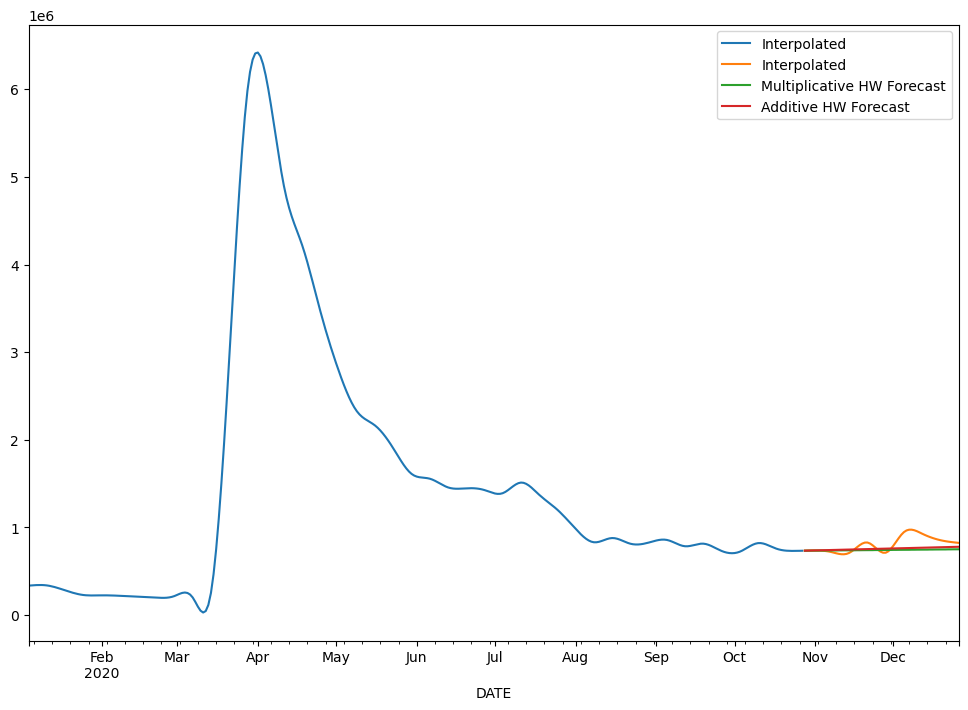

In [55]:
train['Interpolated'].plot(figsize=(12,8),legend=True)
test['Interpolated'].plot(legend=True)
multiplicative_predictions.plot(legend=True)
additive_predictions.plot(legend=True)

Evaluating RMSE

In [56]:
# evaluating using rmse
from sklearn.metrics import mean_squared_error
rmse_additive = np.sqrt(mean_squared_error(test['Interpolated'],additive_predictions))
rmse_multiplicative = np.sqrt(mean_squared_error(test['Interpolated'],multiplicative_predictions))
print("RMSE Of Additive model ",rmse_additive)
print("RMSE Of Multiplicative model ",rmse_multiplicative)

RMSE Of Additive model  90962.30392543113
RMSE Of Multiplicative model  103786.54206167896


Forecasting

In [66]:
# forecasting for future dates using addditive and multiplicative model
add_model = ExponentialSmoothing(covid_daily['Interpolated'],trend='add',seasonal='add').fit()
add_forecast = add_model.forecast(60).rename('Additive HW Forecast')
mul_model = ExponentialSmoothing(covid_daily['Interpolated'],trend='add',seasonal='mul').fit()
mul_forecast = mul_model.forecast(60).rename('Multiplicative HW Forecast')

In [62]:
mul_forecast



2020-12-27    820283.103279
2020-12-28    816982.180407
2020-12-29    814582.186461
2020-12-30    811622.571374
2020-12-31    808638.563636
2021-01-01    805225.957528
2021-01-02    802068.361024
2021-01-03    798843.290462
2021-01-04    795548.613957
2021-01-05    793131.188545
2021-01-06    790168.802912
2021-01-07    787182.650844
2021-01-08    783779.299520
2021-01-09    780624.210544
2021-01-10    777403.477645
2021-01-11    774115.047507
2021-01-12    771680.190629
2021-01-13    768715.034450
2021-01-14    765726.738052
2021-01-15    762332.641512
2021-01-16    759180.060064
2021-01-17    755963.664828
2021-01-18    752681.481058
2021-01-19    750229.192713
2021-01-20    747261.265987
2021-01-21    744270.825259
2021-01-22    740885.983504
2021-01-23    737735.909583
2021-01-24    734523.852011
2021-01-25    731247.914608
2021-01-26    728778.194797
2021-01-27    725807.497525
2021-01-28    722814.912467
2021-01-29    719439.325496
2021-01-30    716291.759103
2021-01-31    713084

In [63]:
mul_model.summary()

Dep. Variable:,Interpolated,No. Observations:,358
Model:,ExponentialSmoothing,SSE,80397285101.781
Optimized:,True,AIC,6906.237
Trend:,Additive,BIC,6948.923
Seasonal:,Multiplicative,AICC,6907.295
Seasonal Periods:,7,Date:,"Wed, 28 Feb 2024"
Box-Cox:,False,Time:,20:54:16
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9950000,alpha,True
smoothing_trend,0.9950000,beta,True


In [64]:
add_forecast

2020-12-27    820431.474117
2020-12-28    817200.692376
2020-12-29    814175.774377
2020-12-30    811127.884861
2020-12-31    808019.451624
2021-01-01    804920.589589
2021-01-02    801753.625244
2021-01-03    798674.201493
2021-01-04    795443.419753
2021-01-05    792418.501754
2021-01-06    789370.612238
2021-01-07    786262.179001
2021-01-08    783163.316966
2021-01-09    779996.352621
2021-01-10    776916.928870
2021-01-11    773686.147130
2021-01-12    770661.229131
2021-01-13    767613.339615
2021-01-14    764504.906378
2021-01-15    761406.044342
2021-01-16    758239.079998
2021-01-17    755159.656247
2021-01-18    751928.874506
2021-01-19    748903.956508
2021-01-20    745856.066992
2021-01-21    742747.633755
2021-01-22    739648.771719
2021-01-23    736481.807374
2021-01-24    733402.383624
2021-01-25    730171.601883
2021-01-26    727146.683885
2021-01-27    724098.794369
2021-01-28    720990.361132
2021-01-29    717891.499096
2021-01-30    714724.534751
2021-01-31    711645

In [65]:
add_model.summary()

Dep. Variable:,Interpolated,No. Observations:,358
Model:,ExponentialSmoothing,SSE,79979674287.891
Optimized:,True,AIC,6904.373
Trend:,Additive,BIC,6947.059
Seasonal:,Additive,AICC,6905.431
Seasonal Periods:,7,Date:,"Wed, 28 Feb 2024"
Box-Cox:,False,Time:,20:55:02
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9950000,alpha,True
smoothing_trend,0.9950000,beta,True


<Axes: xlabel='DATE'>

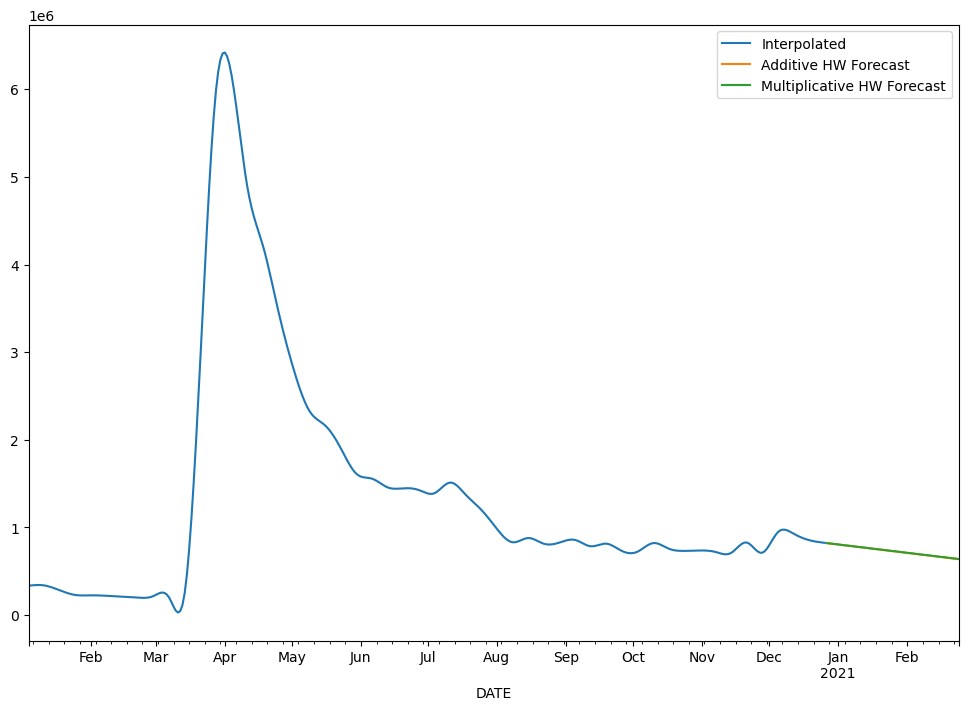

In [58]:
covid_daily['Interpolated'].plot(figsize=(12,8),legend=True)
add_forecast.plot(legend=True)
mul_forecast.plot(legend=True)

In [59]:
# check for the nearest forecasted value
covid_daily.tail()

,ICNSA,Interpolated
DATE,,
2020-12-22,NaN,837679.569657
2020-12-23,NaN,833609.699688
2020-12-24,NaN,829992.381909
2020-12-25,NaN,826676.765590
2020-12-26,823512.0,823512.000000


In [60]:

df.loc[:'2021-01-10'].tail()

,ICNSA
DATE,
2020-12-12,928178
2020-12-19,854113
2020-12-26,823512
2021-01-02,898597
2021-01-09,1082696


In [61]:
# so we can check for '2021-01-02'
print("Original value for 2021-01-02 : ",df.loc['2021-01-02'].ICNSA)
# forecasted value for 2021-01-02 using additive model
print("Forecasted value by additive model for 2021-01-02 : ",add_forecast['2021-01-02'])
print("Error value by additive model for 2021-01-02 : ",df.loc['2021-01-02'].ICNSA-add_forecast['2021-01-02'])
# forecasted value for 2021-01-02 using multiplicative model
print("Forecasted value by multiplicative model for 2021-01-02 : ",mul_forecast['2021-01-02'])
print("Error value by multiplicative model for 2021-01-02 : ",df.loc['2021-01-02'].ICNSA-mul_forecast['2021-01-02'])

Original value for 2021-01-02 :  898597
Forecasted value by additive model for 2021-01-02 :  801753.6252438694
Error value by additive model for 2021-01-02 :  96843.37475613062
Forecasted value by multiplicative model for 2021-01-02 :  802068.3610237646
Error value by multiplicative model for 2021-01-02 :  96528.63897623541


The summary outputs:
1.The multiplicative model exhibits a slightly lower RMSE compared to the additive model, suggesting slightly better data fit in terms of error minimization.
2.AIC and BIC values for both models are quite similar, indicating that there is no substantial disparity in fit quality between two models according to these criteria.
3.Upon observation of the trend component:- There is no huge apparent increase, implying that an additive trend could be suitable.
4.The seasonal component seems constant, further supporting the notion of an additive model.

